## Contains
- [x] Importing the data 
- [x] A few plots 
- [x] Cleaning the data:  <br>- select columns when downloading data, <br>- delete nan, <br>- made "Month" a datetime object, <br>- create LAD columns
- [x] Making the different series per crime type stationary 

## downloading data and packages

In [195]:
%matplotlib inline
import os
import sys
import re
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# I think I would not use the outcomes data, as i dont think it adds anything to the final analysis. 
# It cannot be compared to crime type, and the amount of demand due to the outcome of the crime is already kinda added
# through the harm index. This also indicates demand considering the further legal system. 

def read_data(data_folder, street_cols, outcomes_cols, search_cols):
    outcomes = []
    street = []
    search = []
    
    for folder in os.listdir(data_folder):
        folder = data_folder + '\\' + folder
        for data in os.listdir(folder):
            file_path = folder + '\\' + data
            
#             if 'outcomes' in data:
#                 outcomes.append(file_path)
            if 'street'  in data:
                street.append(file_path)                
            if 'stop-and-search' in data:
                search.append(file_path)
            
    street = pd.concat( [pd.read_csv(f, usecols=street_cols) for f in tqdm(street, position=0, leave=True)] , ignore_index=True)
#     outcomes = pd.concat( [pd.read_csv(f, usecols=outcomes_cols) for f in tqdm(outcomes, position=0, leave=True)] , ignore_index=True)
    search = pd.concat( [pd.read_csv(f, usecols=search_cols) for f in tqdm(search, position=0, leave=True)] , ignore_index=True)                          
                
    return street, outcomes, search

In [34]:
folder = 'Data\\Jan_2010_Oct_2021'

street_cols = ['Month', 'Reported by', 'Falls within', 'Location', 'LSOA code', 'LSOA name', 'Crime type']

outcome_cols = ['Month', 'Reported by', 'Falls within', 'Location', 'LSOA code', 'LSOA name', 'Outcome type']
search_cols = ['Type', 'Date', 'Part of a policing operation', 'Policing operation','Latitude', 'Longitude', 'Legislation', 'Object of search',
              'Outcome', 'Outcome linked to object of search']

street, outcomes, search = read_data(folder, street_cols, outcome_cols, search_cols)

100%|█████████████████████████████████████████████████████████████████████████████| 3438/3438 [00:32<00:00, 104.72it/s]


## Cleaning

In [11]:
# deleting NA values

na_street = street.dropna(axis=0, how="any")
na_outcomes = outcomes.dropna(axis=0, how="any")
na_search = search.dropna(axis=0, subset=['Type', 'Date', 'Latitude', 'Longitude', 'Outcome'],how="any")

In [35]:
# import datetime

na_street['Month dt'] = pd.to_datetime(na_street['Month']).dt.to_period('m')
na_outcomes['Month dt'] = pd.to_datetime(na_outcomes['Month']).dt.to_period('m')
na_search['Month dt'] = pd.to_datetime(na_search['Date']).dt.to_period('m')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [212]:
# delete data prior to 2013 05, due to fewer categories of crime types

na_street = na_street[ na_street['Month dt'] > '2013-05' ]
na_outcomes = na_outcomes[ na_outcomes['Month dt'] > '2013-05' ]
na_search = na_search[ na_search['Month dt'] > '2013-05' ]

### Converting the locations to LAD

In [48]:
conversions = pd.read_csv('Data/conversiontable.csv', encoding="latin-1")

convert_codes = dict(zip(conversions.lsoa11cd, conversions.ladcd))
convert_names = dict(zip(conversions.lsoa11cd, conversions.ladnm))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
na_street['LAD code'] = na_street['LSOA code'].map(convert_codes)
na_street['LAD name'] = na_street['LSOA code'].map(convert_names)

na_outcomes['LAD code'] = na_outcomes['LSOA code'].map(convert_codes)
na_outcomes['LAD name'] = na_outcomes['LSOA code'].map(convert_names)

# for search i need to use longitude and latitude

## Plots

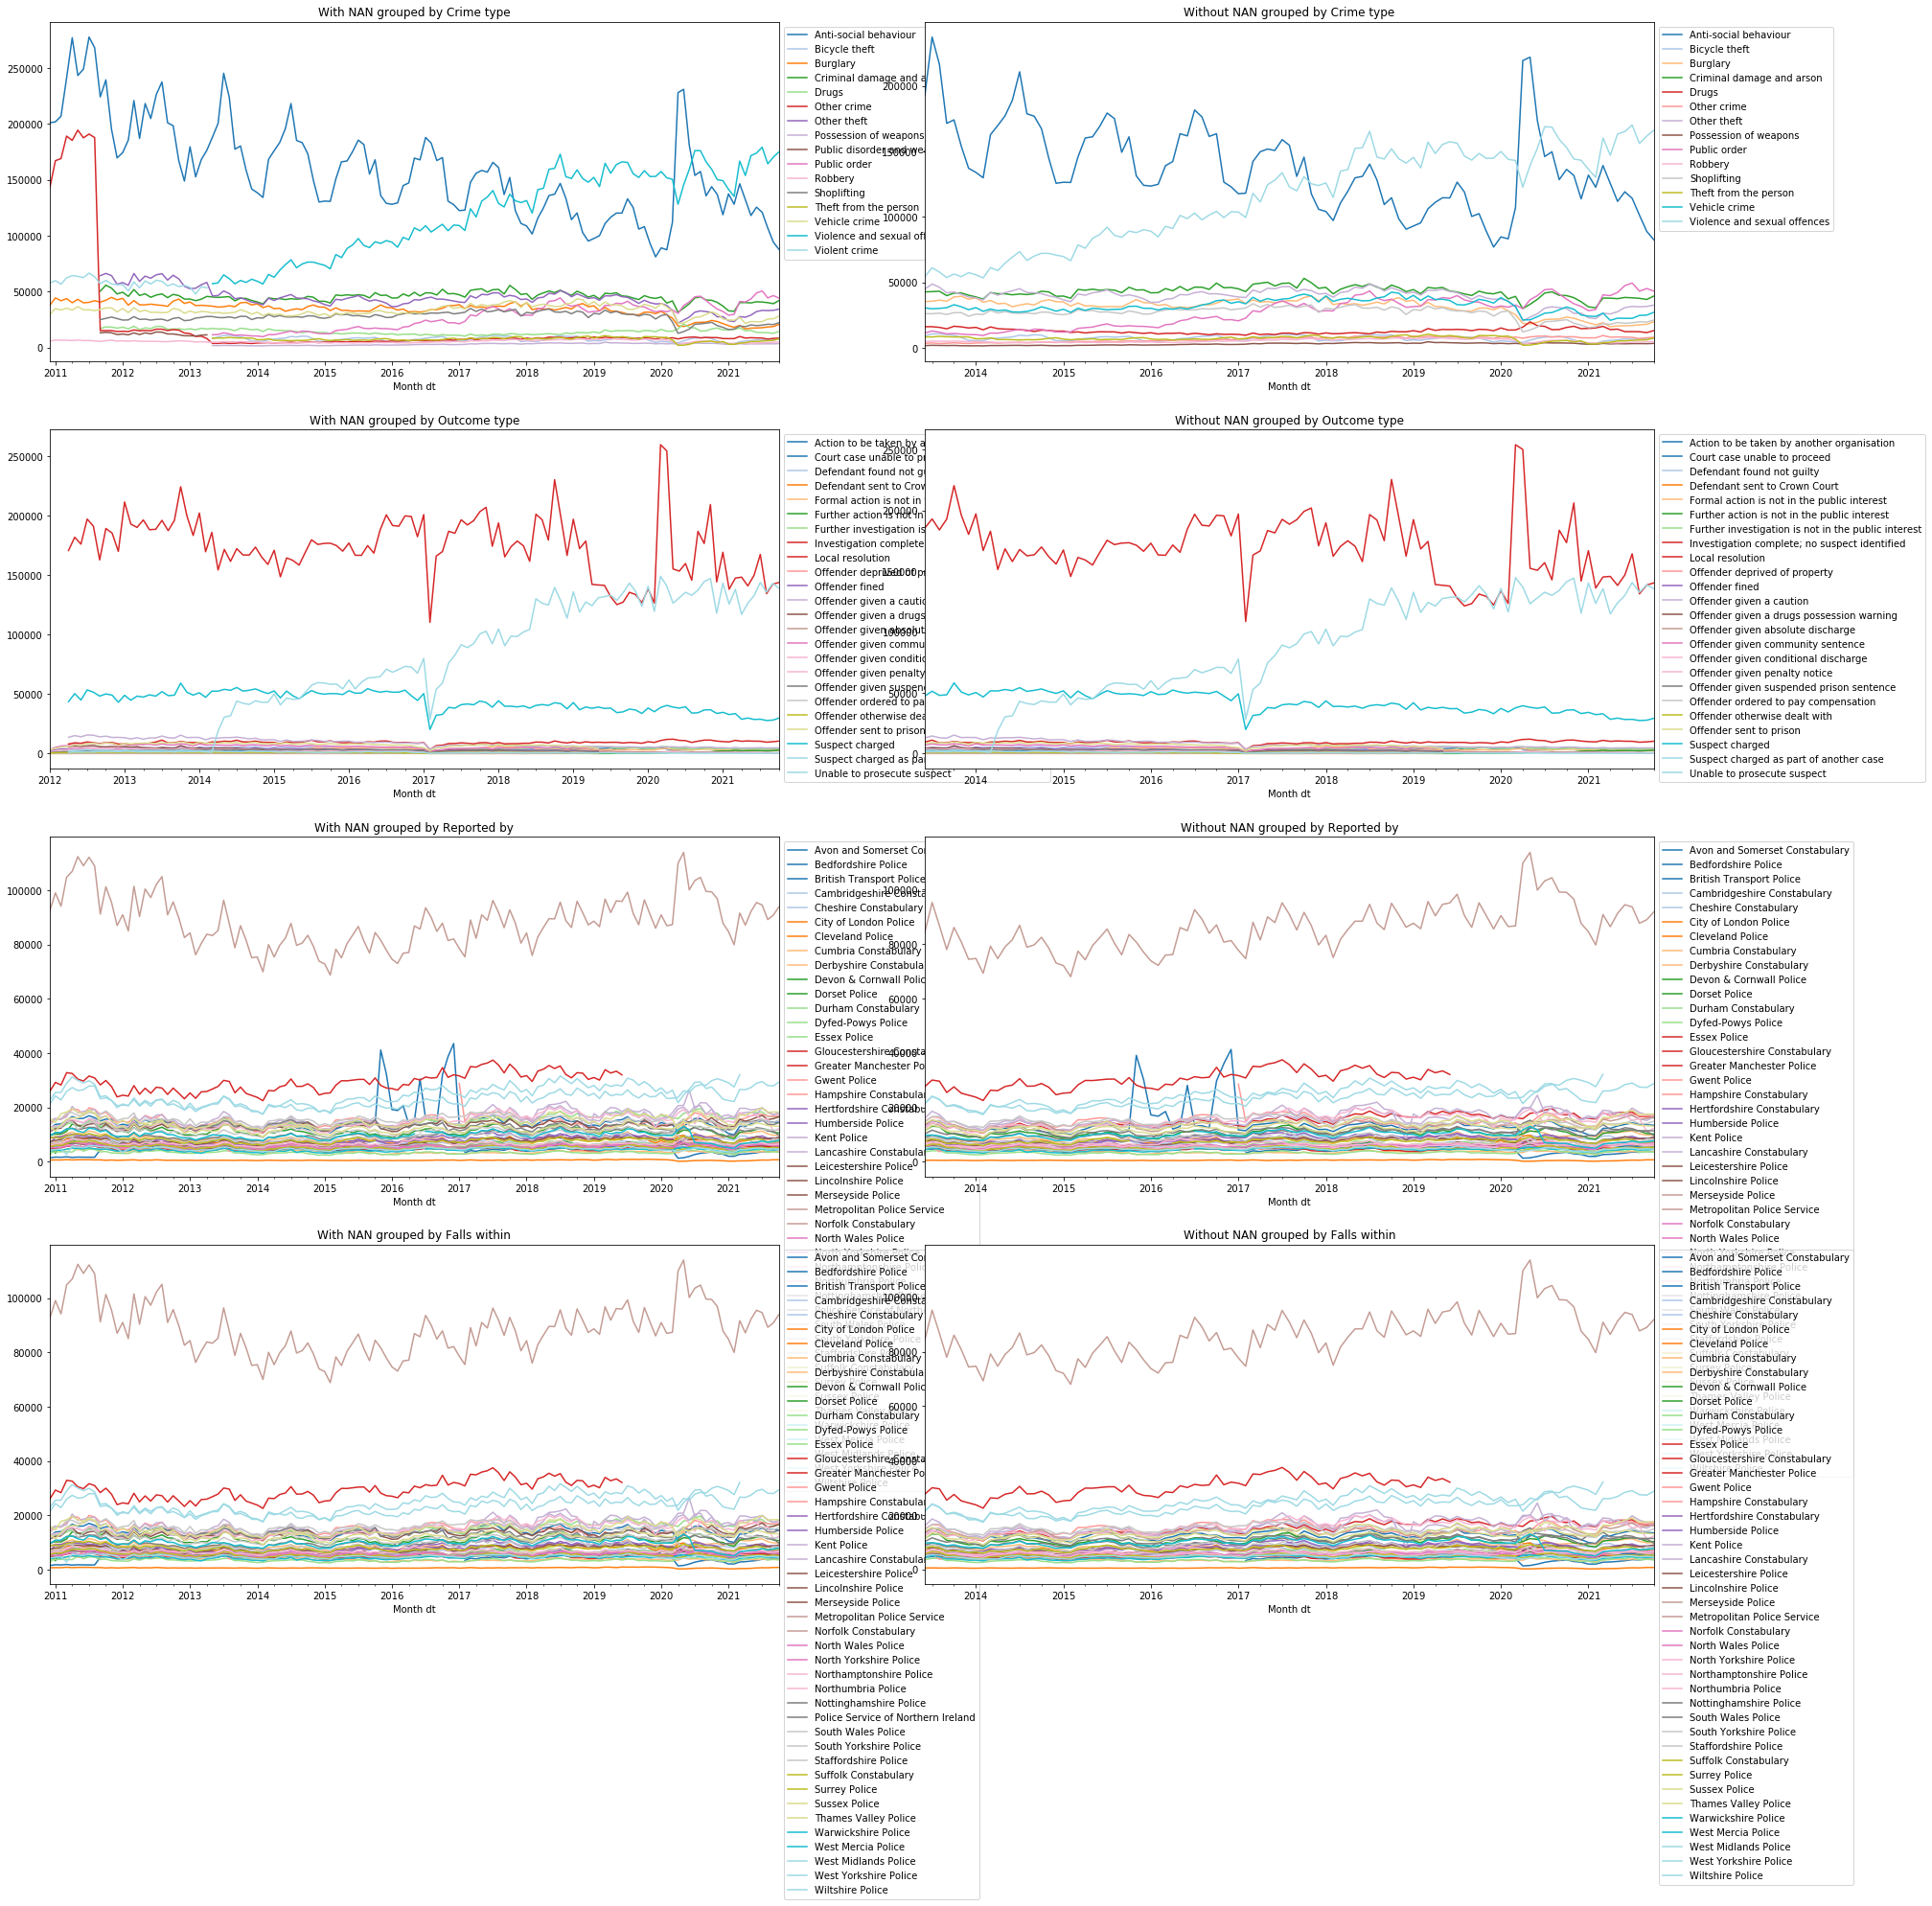

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(30,30))

cols = ['Crime type', 'Outcome type', 'Reported by', 'Falls within']

for i in range(4):
    
    if i == 1: # only plot from the outcomes df
        types = outcomes.groupby(['Month dt', cols[i]]).size() 
        types.unstack().plot(cmap='tab20', ax=axes[i,0])
        axes[i ,0].legend(bbox_to_anchor=(1,1), loc="upper left")
        axes[i ,0].set_title(f'With NAN grouped by {cols[i]}');
        
        types = na_outcomes.groupby(['Month dt', cols[i]]).size() 
        types.unstack().plot(cmap='tab20', ax=axes[i,1])
        axes[ i, 1].legend(bbox_to_anchor=(1,1), loc="upper left")
        axes[ i, 1].set_title(f'Without NAN grouped by {cols[i]}');
        
    else:
        types = street.groupby(['Month dt', cols[i]]).size() 
        types.unstack().plot(cmap='tab20', ax=axes[i,0])
        axes[i ,0].legend(bbox_to_anchor=(1,1), loc="upper left")
        axes[i ,0].set_title(f'With NAN grouped by {cols[i]}');
        
        types = na_street.groupby(['Month dt', cols[i]]).size() 
        types.unstack().plot(cmap='tab20', ax=axes[i,1])
        axes[ i, 1].legend(bbox_to_anchor=(1,1), loc="upper left")
        axes[ i, 1].set_title(f'Without NAN grouped by {cols[i]}');

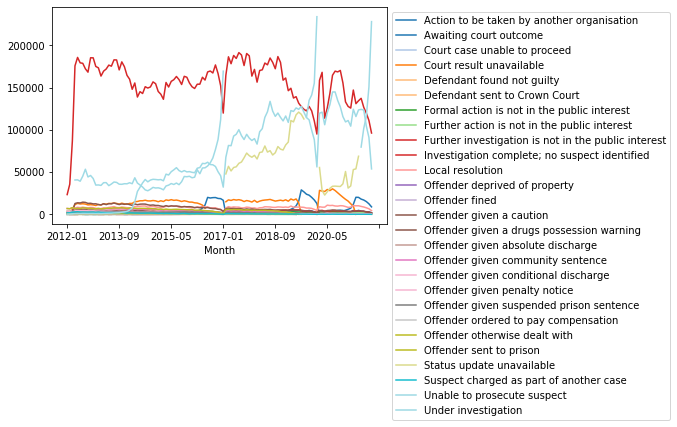

In [30]:
# street df
types = street.groupby(['Month', 'Last outcome category']).size() 
types.unstack().plot(cmap='tab20')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

## Count and unique per df

In [20]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pd.reset_option('display.float_format')

In [55]:
street.agg(['count', 'nunique'])

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Month dt,LAD code,LAD name
count,67623292,67623292,67623292,67623292,64986276,64986276,67623292,67623292,64986276,64986276
nunique,131,45,45,289081,34750,34750,16,131,339,339


In [56]:
outcomes.agg(['count', 'nunique'])

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Outcome type,Month dt
count,39997302,39997302,39997302,39997302,39160487,39160487,39997302,39997302
nunique,118,43,43,261960,34749,34749,24,118


In [57]:
search.agg(['count', 'nunique'])

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Legislation,Object of search,Outcome,Outcome linked to object of search,Month dt
count,2898964,2898964,1791547,22518,2216603,2216603,2746271,2632433,2839285,799563,2898964
nunique,3,1348785,2,1672,246904,251829,21,17,16,2,92


## time series analysis

In [216]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    # H0 non-stationarity
    
    dftest = adfuller(timeseries.dropna(), autolag='BIC')
    stationary = dftest[1] < 0.05   # reject H0 of unit root at 1% 
#     print('{} stationarity is {}'.format(dataDesc,stationary))
    return stationary

In [207]:
dftest = adfuller(y.dropna(), autolag='BIC')
dftest

(-3.6014937114318277,
 0.005732535321173053,
 9,
 55,
 {'1%': -3.5552728880540942,
  '5%': -2.9157312396694217,
  '10%': -2.5956695041322315},
 149.36516749542346)

In [217]:
for crime in na_street['Crime type'].unique():
    y = na_street[ na_street['Crime type'] == crime ].set_index('Month dt').groupby('Month dt').size()
    ADF_test(y, crime)

Violence and sexual offences stationarity is False
Anti-social behaviour stationarity is False
Burglary stationarity is False
Criminal damage and arson stationarity is False
Other theft stationarity is False
Vehicle crime stationarity is False
Drugs stationarity is False
Public order stationarity is False
Shoplifting stationarity is False
Theft from the person stationarity is False
Other crime stationarity is False
Bicycle theft stationarity is False
Robbery stationarity is False
Possession of weapons stationarity is False


### Detrend and differencing

In [201]:
# na_street = na_street[ na_street['Month dt'] < '2020-01' ]
# could covid be considered a surge?

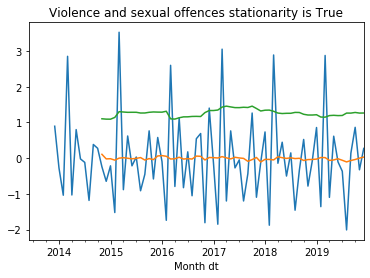

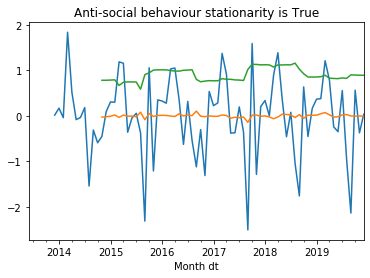

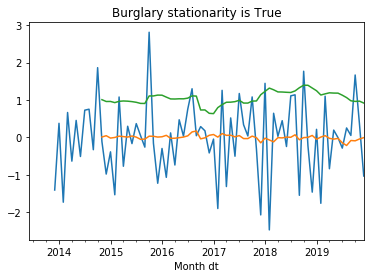

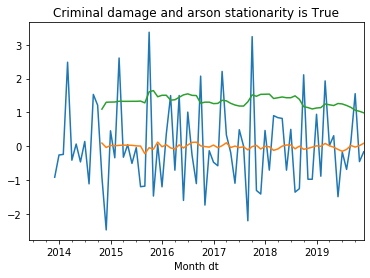

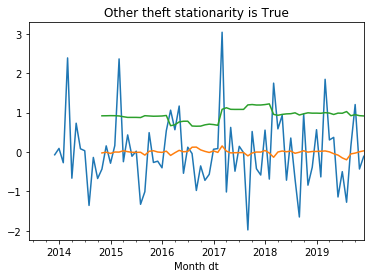

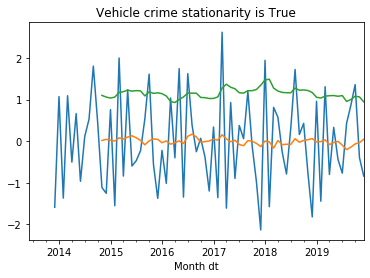

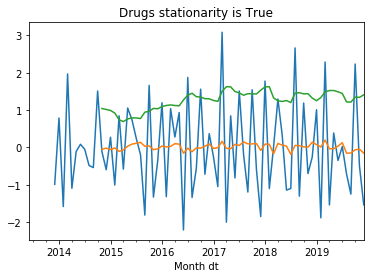

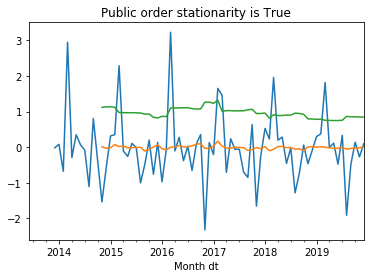

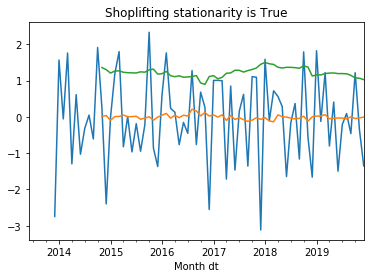

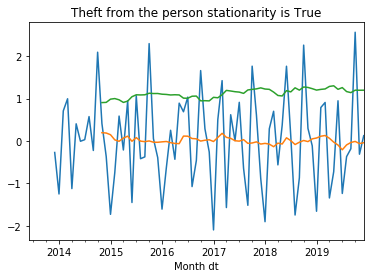

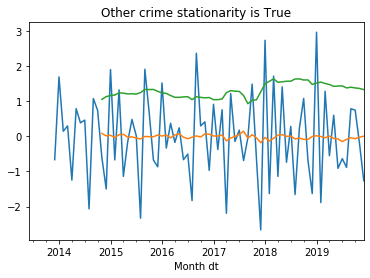

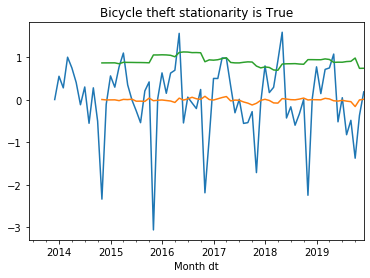

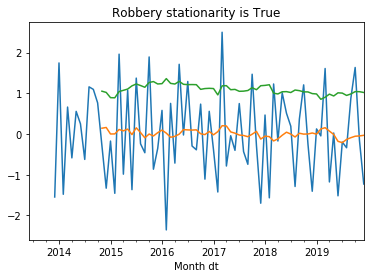

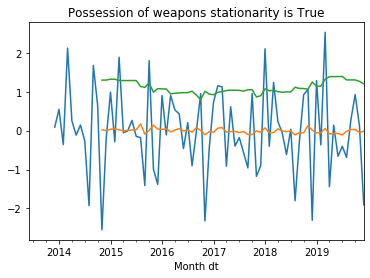

In [214]:
for crime in na_street['Crime type'].unique():
    y = na_street[ na_street['Crime type'] == crime ].set_index('Month dt').groupby('Month dt').size()
    stationary = ADF_test(y, crime)
    
    if ~stationary:
        y =  (y - y.rolling(window=6).mean())/y.rolling(window=6).std()
        y =  y - y.shift(1)
        
    stationary = ADF_test(y, crime)   
    
    plt.figure()
    y.plot()
    pd.Series(y).rolling(window=12).mean().plot()
    pd.Series(y).rolling(window=12).std().plot()
    plt.title(f'{crime} stationarity is {stationary}');
    plt.show()